#  Генерация текста с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html


## Задачи для совместного разбора

1\. Рассмотрите основные шаги обучения модели для генерации текста с использованием RNN.

![text gen](https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png)

В этой ЛР мы рассматриваем задачу генерации текста. Верхнеуровнево это выглядит так: по текущему токену и некоторой информации о предыдущих токенах наша цель - сгенерировать следующий токен. Похожие вещи мы раньше делали, оценивая вероятностные распределения. Модель на биграммах - частный случай (история = один предыдущий токен).

Теперь мы усложняем модель и в качестве истории используем вектор скрытого состояния RNN, который получен после обработки части последовательности. Новый промежуточный вектор скрытого состояния можно использовать для прогноза следующего токена.

In [28]:
import torch as th

batch_size, seq_len, vocab_size = 8, 5, 10
data = th.randint(0, vocab_size, size=(batch_size, seq_len)) # входные последовательности
data

tensor([[6, 2, 2, 7, 5],
        [1, 8, 5, 9, 9],
        [8, 6, 8, 9, 9],
        [6, 5, 3, 9, 2],
        [4, 6, 5, 2, 6],
        [8, 9, 8, 3, 6],
        [3, 3, 0, 5, 8],
        [6, 0, 5, 4, 4]])

Для обучения нужны примеры и ответы. Мы можем получить их из исходных данных, имея в виду решаемую задачу. Для конкретного токена правильный "ответ" в нашей постановке задачи - это следующий за ним токен

In [ ]:
X_t = X[:, :-1]
y_t = X[:, 1:]

In [ ]:
import torch.nn as nn

embedding_dim = 10
emb = nn.Embedding(num_embeddings=10, embedding_dim=embedding_dim) # каждый токен заменяем на вектор
X_e = emb(X_t)
X_e.shape

torch.Size([8, 4, 10])

In [ ]:
hidden_size = 7
rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True) 

out, h = rnn(X_e) # пропускаем последовательности через RNN
out.shape

torch.Size([8, 4, 7])

out - это векторы скрытых состояний после обработки очередного элемента последовательностей. Для каждого примера батча есть 4 (seq_len - 1) таких векторов. Каждый из них мы можем использовать для прогноза

In [ ]:
fc = nn.Linear(hidden_size, vocab_size)
y_preds = fc(out)
y_preds.shape

torch.Size([8, 4, 10])

На этом этапе у нас каждый из векторов имеет размерность 10 (по количеству уникальных токенов в словаре). Каждый из этих векторов трактуем как логиты. Цель - добиться того, чтобы логит, соответствующий правильному ответу (реально идущему далее слову) был побольше. В этом месте нам уже не нужна трехмерная структура.

In [ ]:
y_preds_2d = y_preds.reshape(batch_size * (seq_len - 1), -1)
y_preds_2d.shape

torch.Size([32, 10])

In [ ]:
y_t.flatten().shape

torch.Size([32])

Теперь можно посчитать значение функции потерь и поотпимизировать его в стандартном цикле обучения.

Во всей этой процедуре есть один токен, который будет встречаться очень часто - PAD. Вопрос: какое воздействие он должен оказывать на итоговое значение функции потерь? По факту, нас не интересуют прогнозы для этих токенов, т.к. они чисто служебные. Для учета этого факта можно рассмотреть параметр ignore_index при создании функции потерь. 

## Задачи для самостоятельного решения

In [306]:
import torch
import re
import numpy as np
import torch.nn as nn
import pandas as pd
import tokenizers
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

<p class="task" id="1"></p>

1\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Tokenizer на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`. Выведите на экран количество токенов в полученном словаре. 

- [ ] Проверено на семинаре

In [240]:
pets_data = pd.read_csv('/home/luchian/all_data/my_notebooks_data/pets_ru_en.csv')
print(pets_data.shape)
pets_data

(2913, 2)


,имя,язык
0,Acapella,en
1,Achilles,en
2,Adriana,en
3,Alpha,en
4,Alyssum,en
...,...,...
2908,Ярика,rus
2909,Яриска,rus
2910,Ярка,rus
2911,Яркиса,rus


In [241]:
class PetsData(object):
    def __init__(self,dataset):
        self.main_data = dataset

    def __getitem__(self,indx):
        string,lang = self.main_data.iloc[indx,:]
        string_found = re.findall(r"(.)",string)
        return ' '.join(string_found)
    
    def __len__(self):
        return len(self.main_data)

In [242]:
some_iter = iter(PetsData(pets_data))
some_iter

In [243]:
next(some_iter)

'A c a p e l l a'

In [244]:
pets_tokenizer = Tokenizer(WordLevel())
pets_trainer = tokenizers.trainers.WordLevelTrainer(special_tokens = ['[PAD]','[SOS]','[EOS]'])

In [245]:
pets_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
pets_tokenizer.normalizer = tokenizers.normalizers.Lowercase()

In [246]:
pets_tokenizer.train_from_iterator(PetsData(pets_data),trainer=pets_trainer)

In [247]:
for name in pets_data['имя']:
    if '-' in name:
        print(name)

Жу-жа
Зум-Зум
Ли-Ли
Лу-лу
Нэко-тян
Неко-мими
Неко-тян
Ума-умочка
Фи-фи
Чио-чио-сан
Шу-шу
Ши-ши
Ю-Ю
Юфи-юф
Юм-юм


In [248]:
pets_tokenizer.get_vocab_size()

62

In [249]:
pets_tokenizer.get_vocab()

{'е': 12,
 'с': 8,
 'я': 22,
 'л': 7,
 'r': 9,
 'т': 19,
 'y': 34,
 'ф': 35,
 'р': 13,
 'k': 45,
 'ь': 37,
 'i': 14,
 'ц': 53,
 'l': 18,
 'w': 51,
 '[SOS]': 1,
 'э': 39,
 'д': 32,
 'ы': 56,
 'а': 3,
 't': 20,
 'у': 25,
 'g': 38,
 'б': 40,
 'п': 36,
 'f': 43,
 'о': 21,
 'к': 11,
 'ч': 46,
 'v': 52,
 's': 17,
 'p': 27,
 'o': 15,
 'и': 4,
 'e': 5,
 'h': 31,
 '[PAD]': 0,
 '[EOS]': 2,
 'ш': 28,
 'г': 44,
 'j': 57,
 'x': 55,
 'a': 6,
 'ё': 59,
 'щ': 61,
 'н': 10,
 'z': 54,
 '-': 58,
 'з': 41,
 'b': 33,
 'q': 60,
 'м': 23,
 'c': 24,
 'й': 47,
 'u': 26,
 'n': 16,
 'ю': 50,
 'd': 30,
 'm': 29,
 'в': 42,
 'ж': 48,
 'х': 49}

In [250]:
pets_tokenizer.token_to_id('[PAD]')

0

In [251]:
pets_tokenizer.token_to_id('[SOS]')

1

In [252]:
pets_tokenizer.token_to_id('[EOS]')

2

<p class="task" id="2"></p>

2\. Создайте класс `PetsGenDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами) и добавьте в начало каждого набора индекс `<SOS>`, а в конец - индекс токена `<EOS>`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)` в соответствии с приведенным рисунком. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

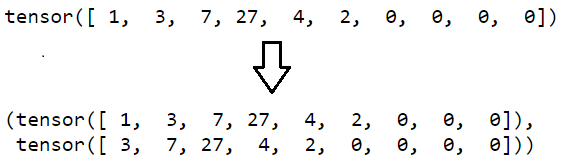

- [ ] Проверено на семинаре

In [253]:
class Padding(object):
    def __init__(self,pad = 24):
        self.pad = pad 

    def __call__(self,X):
        the_dtype = X.dtype
        ret_tensor = torch.zeros(self.pad,dtype = the_dtype)
        ret_tensor[:X.shape[0]] = X
        return ret_tensor

In [254]:
class PetsGenDataset(Dataset):
    def __init__(self,data,transforms = None,tokenizer = pets_tokenizer):
        self.main_data = data
        self.transforms = transforms
        self.tokenizer = tokenizer
    
    def __getitem__(self,indx):
        tens = torch.LongTensor([pets_tokenizer.token_to_id(one_token[0].lower()) for one_token in self.tokenizer.pre_tokenizer.pre_tokenize_str(self.main_data[indx])])
        sos = torch.tensor(self.tokenizer.token_to_id('[SOS]'),dtype = torch.int64).reshape(1)
        eos = torch.tensor(self.tokenizer.token_to_id('[EOS]'),dtype = torch.int64).reshape(1)
        pad = torch.tensor(self.tokenizer.token_to_id('[PAD]'),dtype = torch.int64).reshape(1)
        tens = torch.cat([sos,tens,eos]) if self.transforms == None else self.transforms(torch.cat([sos,tens,eos]))
        return tens,torch.cat([tens[1:],pad])
    
    def __len__(self):
        return len(self.main_data)

In [255]:
names = pets_data['имя']
len(max(names.tolist(),key = lambda x: len(x)))

22

In [256]:
my_pets_dataset = PetsGenDataset(PetsData(pets_data),Padding())
my_pets_dataset

In [257]:
testing_loader = DataLoader(dataset = my_pets_dataset,shuffle = True,batch_size = 128)
testing_loader

In [258]:
one_sample = next(iter(testing_loader))
len(one_sample)

2

In [259]:
one_sample[0].shape,one_sample[1].shape

(torch.Size([128, 24]), torch.Size([128, 24]))

In [260]:
print(one_sample[0][0])
print(one_sample[1][0])

tensor([ 1, 33, 18, 14, 16, 38,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])
tensor([33, 18, 14, 16, 38,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])


<p class="task" id="3"></p>

3\. Напишите функцию, которая генерирует имя питомца при помощи обученной модели:
  * построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * начальное скрытое состояние RNN `h_t = None`;
  * в результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности;
  * функция возвращает строку из букв с первой заглавной буквой.
  
- [ ] Проверено на семинаре

In [278]:
def generate_name(model,tokenizer,dev = 'cuda'):
    model.eval()
    generated_tokens = []
    sos = torch.tensor(tokenizer.token_to_id('[SOS]'),dtype = torch.int64).reshape(1).to(device = dev)
    current_pred = sos
    while current_pred != tokenizer.token_to_id('[EOS]'):
        y_pred = model(current_pred)
        probs = y_pred.cpu().softmax(dim = 1)
        distr_item = torch.multinomial(probs,num_samples=1).reshape(-1).to(device = dev)
        letter = tokenizer.id_to_token(distr_item.item())
        if letter != '[EOS]':
            generated_tokens.append(letter)
        current_pred = distr_item
    return ''.join(generated_tokens).capitalize()


In [283]:
probs = generate_name(LangModel,pets_tokenizer)
probs

'Фскшцфлuf[sos]ююгпзюzжц'

<p class="task" id="4"></p>

4\. Создайте и обучите модель для генерации имени питомца. Задача классификации ставится как предсказание следующего токена в каждом примере из пакета для каждого элемента последовательности (по прочитанной подстроке предсказывается следующий символ для данной строки). Каждые несколько эпох выводите примеры генерации имен при помощи текущего состояния модели. Игнорируйте токен `<PAD>` при расчете ошибки. 

Примерная схема реализации метода `forward`:
```
input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size] 
output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
```

- [ ] Проверено на семинаре

In [25]:
vocab_size = pets_tokenizer.get_vocab_size()
vocab_size

62

In [26]:
embd = nn.Embedding(num_embeddings=vocab_size,embedding_dim = 10,padding_idx = 0)
embd

Embedding(62, 10, padding_idx=0)

In [27]:
x = one_sample[0]
x.shape

torch.Size([128, 24])

In [28]:
y = embd(x)
y.shape

torch.Size([128, 24, 10])

In [29]:
targets = one_sample[1]
targets.shape

torch.Size([128, 24])

In [30]:
some_rnn = nn.RNN(input_size = 10,hidden_size=5)
some_rnn

RNN(10, 5)

In [31]:
y = some_rnn(y)


In [32]:
y[0].shape

torch.Size([128, 24, 5])

In [33]:
y = y[0].reshape(128*24,5)

In [34]:
some_lin = nn.Linear(5,vocab_size)

In [35]:
tar = some_lin(y)
tar.shape

torch.Size([3072, 62])

In [36]:
true = targets.reshape(-1)

In [37]:
true.shape

torch.Size([3072])

In [38]:
the_loss = nn.CrossEntropyLoss()

In [39]:
the_loss(tar,true)

tensor(4.0655, grad_fn=<NllLossBackward0>)

In [377]:
class LanguageModel(nn.Module):
    def __init__(self,input_size,hidden_size,tokenizer = pets_tokenizer,embd_dim = 5,lins = 128):
        super(LanguageModel,self).__init__()
        self.tokenizer = tokenizer
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embd_dim = embd_dim
        self.lins = lins
        #layers
        self.rel = nn.ReLU()
        self.drop = nn.Dropout1d(p=0.15)
        self.rnn1 = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size)
        self.rnn2 = nn.LSTM(input_size=self.hidden_size,hidden_size=self.hidden_size)
        self.embd = nn.Embedding(num_embeddings=self.tokenizer.get_vocab_size(),embedding_dim = self.embd_dim,padding_idx=0)
        self.lin1 = nn.Linear(self.hidden_size,self.lins)
        self.lin2 = nn.Linear(self.lins,self.tokenizer.get_vocab_size())
    
    def forward(self,X):
        xx = self.embd(X)
        xx = xx if len(xx.size()) == 3 else xx.unsqueeze(dim = 0)
        
        y = self.rnn1(xx)[0]
        y = self.rnn2(y)[0]
        y = y.unsqueeze(dim = 0) if len(y.size()) == 2 else y
        y = y.reshape(y.shape[0]*y.shape[1],self.hidden_size)
        
        y = self.lin1(y)
        y = self.rel(y)
        y = self.drop(y)

        y = self.lin2(y)
        return y

In [390]:
training_dataset = PetsGenDataset(PetsData(pets_data),Padding())
LangModel = LanguageModel(
    input_size=12,
    hidden_size=32,
    tokenizer=pets_tokenizer,
    embd_dim = 12,
    lins = 32
).to(device = 'cuda')

In [391]:
loss = nn.CrossEntropyLoss(reduction='mean')
epoch = 32
batch_size = 64
lr = 0.03
the_optim = torch.optim.Adam(LangModel.parameters(),lr = lr,betas = (0.9,0.99))

In [392]:
train_loader = DataLoader(dataset = training_dataset,shuffle = True,batch_size = batch_size)

In [393]:
def train_model(
        model,
        loss,
        the_optim,
        epoch,
        loader,
        dev = 'cuda',
        print_every = 2
):
    loss_list = []
    for ep in range(epoch):
        model.train()
        for X,y in loader:
            X,y = X.to(device = dev),y.to(device = dev)
            y_pred = model(X)
            y = y.reshape(-1)
            batch_loss = loss(y_pred,y)
            batch_loss.backward()
            loss_list.append(round(batch_loss.item(),5))
            the_optim.step()
            the_optim.zero_grad()
        if ep % print_every == 0:
            print(f'Epoch #{ep} | TrainLoss: {loss_list[-1]} | Generated word: {generate_name(model=model,tokenizer=model.tokenizer,dev = dev)}') #word here should be 
    return loss_list   

In [394]:
the_losses = train_model(
    model=LangModel,
    loss = loss,
    the_optim=the_optim,
    epoch=epoch,
    loader = train_loader    
)

Epoch #0 | TrainLoss: 1.49107 | Generated word: Каaaоюбооффе
Epoch #2 | TrainLoss: 0.98999 | Generated word: Аphnелtnа
Epoch #4 | TrainLoss: 0.90642 | Generated word: Ревоокиянипьтаса
Epoch #6 | TrainLoss: 0.94737 | Generated word: Лишсаа
Epoch #8 | TrainLoss: 0.85583 | Generated word: Юшка
Epoch #10 | TrainLoss: 0.87207 | Generated word: Ola
Epoch #12 | TrainLoss: 0.87462 | Generated word: На
Epoch #14 | TrainLoss: 0.83579 | Generated word: Датирушаньмосогонокардронкайранейнаб
Epoch #16 | TrainLoss: 0.91493 | Generated word: Irtis[pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pad][pa

In [403]:
def plot_losses(loss_list):
    some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
    some_ax = some_figure.add_subplot()
    some_ax.grid(linestyle = '--',color = 'blue',alpha = 0.3)
    some_ax.plot(loss_list,color = 'red')
    some_ax.set_xlabel(f'Loss over batches')
    some_ax.set_ylabel(f'Loss function')
    return some_ax

<Axes: xlabel='Loss over batches', ylabel='Loss function'>

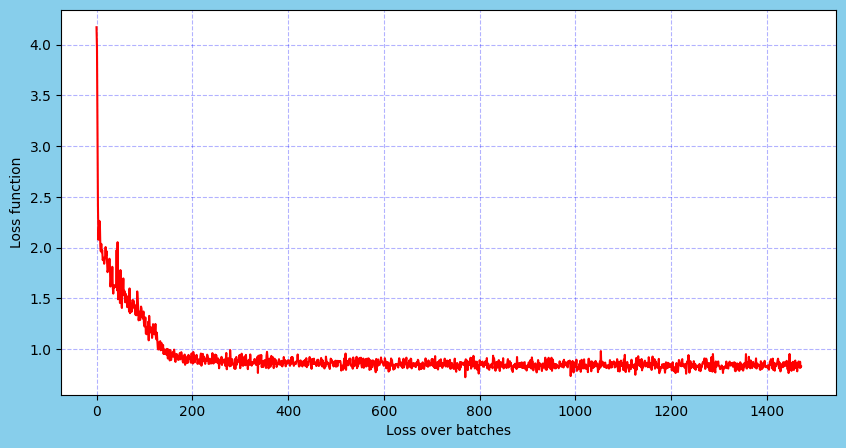

In [404]:
plot_losses(the_losses)

<p class="task" id="5"></p>

5\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`, `<RU>`, `<EN>`. Выведите на экран количество токенов в полученном словаре. 

Модифицируйте датасет `PetsGenDataset` таким образом, чтобы в начало каждого примера добавлялся токен `<RU>`, если это имя питомца на русском, и `<EN>`, если имя на английском. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

- [ ] Проверено на семинаре

In [405]:
pets_data = pd.read_csv('/home/luchian/all_data/my_notebooks_data/pets_ru_en.csv')
print(pets_data.shape)
pets_data

(2913, 2)


,имя,язык
0,Acapella,en
1,Achilles,en
2,Adriana,en
3,Alpha,en
4,Alyssum,en
...,...,...
2908,Ярика,rus
2909,Яриска,rus
2910,Ярка,rus
2911,Яркиса,rus


In [406]:
class PetsData(object):
    def __init__(self,dataset):
        self.main_data = dataset

    def __getitem__(self,indx):
        string,lang = self.main_data.iloc[indx,:]
        string_found = re.findall(r"(.)",string)
        return ' '.join(string_found)
    
    def __len__(self):
        return len(self.main_data) 

In [407]:
some_iter = iter(PetsData(pets_data))
some_iter

In [408]:
next(some_iter)

'A c a p e l l a'

In [409]:
pets_tokenizer = Tokenizer(WordLevel())
pets_trainer = tokenizers.trainers.WordLevelTrainer(special_tokens = ['[PAD]','[SOS]','[EOS]','[RU]','[ENG]'])

In [410]:
pets_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
pets_tokenizer.normalizer = tokenizers.normalizers.Lowercase()

In [411]:
pets_tokenizer.train_from_iterator(PetsData(pets_data),trainer=pets_trainer)

In [412]:
pets_tokenizer.get_vocab_size()

64

In [413]:
pets_tokenizer.token_to_id('[RU]')

3

In [414]:
pets_tokenizer.token_to_id('[ENG]')

4

In [415]:
class Padding(object):
    def __init__(self,pad = 26):
        self.pad = pad 

    def __call__(self,X):
        the_dtype = X.dtype
        ret_tensor = torch.zeros(self.pad,dtype = the_dtype)
        ret_tensor[:X.shape[0]] = X
        return ret_tensor

In [521]:
class PetsGenDataset(Dataset):
    def __init__(self,data,transforms = None,tokenizer = pets_tokenizer):
        self.main_data = data
        self.transforms = transforms
        self.tokenizer = tokenizer
    
    def __getitem__(self,indx):
        tens = torch.LongTensor([pets_tokenizer.token_to_id(one_token[0].lower()) for one_token in self.tokenizer.pre_tokenizer.pre_tokenize_str(self.main_data[indx])])
        #tokens 
        ru = torch.tensor(self.tokenizer.token_to_id('[RU]'),dtype = torch.int64).reshape(1)
        eng = torch.tensor(self.tokenizer.token_to_id('[ENG]'),dtype = torch.int64).reshape(1)
        sos = torch.tensor(self.tokenizer.token_to_id('[SOS]'),dtype = torch.int64).reshape(1)
        eos = torch.tensor(self.tokenizer.token_to_id('[EOS]'),dtype = torch.int64).reshape(1)
        pad = torch.tensor(self.tokenizer.token_to_id('[PAD]'),dtype = torch.int64).reshape(1)
        #check ru or eng
        if re.findall('[A-z]',self.main_data[indx]):
            tens = torch.cat([eng,tens])
        else:
            tens = torch.cat([ru,tens])
        tens = torch.cat([sos,tens,eos]) if self.transforms == None else self.transforms(torch.cat([sos,tens,eos]))
        return tens,torch.cat([tens[1:],pad])
    
    def __len__(self):
        return len(self.main_data)

In [522]:
the_dataset = PetsGenDataset(PetsData(pets_data),transforms=Padding(26))
the_dataset

In [523]:
the_dataset[1532]

(tensor([ 1,  3, 43,  5, 21, 14, 24,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([ 3, 43,  5, 21, 14, 24,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0]))

In [524]:
testing_loader = DataLoader(dataset = the_dataset,shuffle = True,batch_size = 128)
testing_loader

one_sample = next(iter(testing_loader))
len(one_sample)

one_sample[0].shape,one_sample[1].shape

(torch.Size([128, 26]), torch.Size([128, 26]))

<p class="task" id="6"></p>

6\. Модифицируйте функцию для генерации имени, добавив возможность указать первый токен - `<RU>` или `<EN>`. Создайте и обучите модель для генерации имени питомца с указанием языка. Каждые несколько эпох выводите примеры генерации русскоязычных и англоязычных имен при помощи текущего состояния модели . Игнорируйте токен `<PAD>` при расчете ошибки. 

- [ ] Проверено на семинаре


In [528]:
def generate_name(model,tokenizer,dev = 'cuda',lang = 'ru'):
    model.eval()
    generated_tokens = []
    lang = torch.tensor(tokenizer.token_to_id('[RU]' if lang == 'ru' else '[ENG]'),dtype = torch.int64).reshape(1).to(device = dev)
    current_pred = lang
    while current_pred != tokenizer.token_to_id('[EOS]'):
        y_pred = model(current_pred)
        probs = y_pred.cpu().softmax(dim = 1)
        distr_item = torch.multinomial(probs,num_samples=1).reshape(-1).to(device = dev)
        letter = tokenizer.id_to_token(distr_item.item())
        if letter != '[EOS]':
            generated_tokens.append(letter)
        current_pred = distr_item
    return ''.join(generated_tokens).capitalize()


In [533]:
training_dataset = the_dataset
LangModel_lang = LanguageModel(
    input_size=12,
    hidden_size=32,
    tokenizer=pets_tokenizer,
    embd_dim = 12,
    lins = 32
).to(device = 'cuda')

In [534]:
loss = nn.CrossEntropyLoss(reduction='mean')
epoch = 32
batch_size = 64
lr = 0.03
the_optim = torch.optim.Adam(LangModel_lang.parameters(),lr = lr,betas = (0.9,0.99))

In [535]:
train_loader = DataLoader(dataset = training_dataset,shuffle = True,batch_size = batch_size)

In [536]:
def train_model(
        model,
        loss,
        the_optim,
        epoch,
        loader,
        dev = 'cuda',
        print_every = 2
):
    loss_list = []
    for ep in range(epoch):
        model.train()
        for X,y in loader:
            X,y = X.to(device = dev),y.to(device = dev)
            y_pred = model(X)
            y = y.reshape(-1)
            batch_loss = loss(y_pred,y)
            batch_loss.backward()
            loss_list.append(round(batch_loss.item(),5))
            the_optim.step()
            the_optim.zero_grad()
        if ep % print_every == 0:
            print(f'Epoch #{ep} | TrainLoss: {loss_list[-1]} | ru_word: {generate_name(model=model,tokenizer=model.tokenizer,dev = dev,lang = 'ru')}| eng_word: {generate_name(model=model,tokenizer=model.tokenizer,dev = dev,lang = 'eng')}')  
    return loss_list   

In [537]:
the_losses = train_model(
    model=LangModel_lang,
    loss = loss,
    the_optim=the_optim,
    epoch=epoch,
    loader = train_loader    
)

Epoch #0 | TrainLoss: 1.31159 | ru_word: Gidлtа| eng_word: Яаcе
Epoch #2 | TrainLoss: 0.85638 | ru_word: Aogbkij[ru]савэ[ru]на| eng_word: Roвёзаса
Epoch #4 | TrainLoss: 0.85812 | ru_word: Erae| eng_word: Tblofhornи
Epoch #6 | TrainLoss: 0.90592 | ru_word: Фянэса| eng_word: Hitiwanncinun
Epoch #8 | TrainLoss: 0.86378 | ru_word: Ва| eng_word: Nrodoococan
Epoch #10 | TrainLoss: 0.79709 | ru_word: -ин| eng_word: Gdя
Epoch #12 | TrainLoss: 0.81657 | ru_word: Вялллька| eng_word: Inas
Epoch #14 | TrainLoss: 0.9018 | ru_word: Фття| eng_word: O
Epoch #16 | TrainLoss: 0.8676 | ru_word: А| eng_word: Yshm
Epoch #18 | TrainLoss: 0.77997 | ru_word: Nn| eng_word: Llldtasaiesy
Epoch #20 | TrainLoss: 0.86177 | ru_word: Ухля| eng_word: Foy
Epoch #22 | TrainLoss: 0.80221 | ru_word: [eng]wansaisianctwieylaylilthertba| eng_word: Abackpamerilenipaztritraрминка
Epoch #24 | TrainLoss: 0.8284 | ru_word: Ди| eng_word: Boro
Epoch #26 | TrainLoss: 0.79105 | ru_word: Шкулитисафлуkcer| eng_word: H
Epoch #28 | Train

<Axes: xlabel='Loss over batches', ylabel='Loss function'>

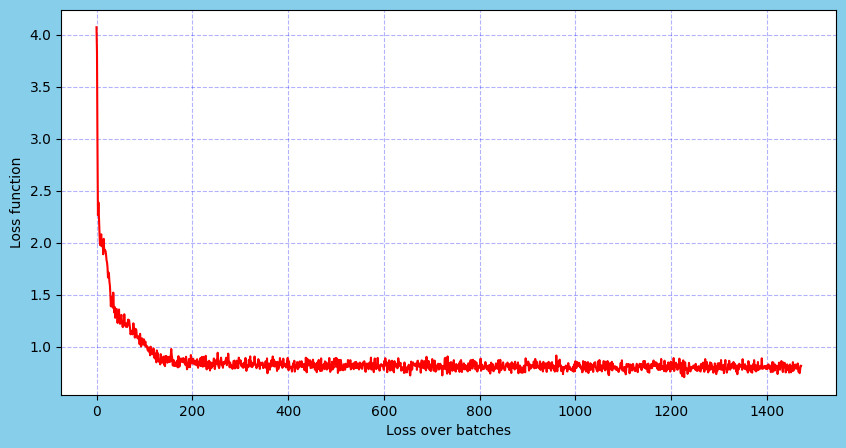

In [538]:
plot_losses(the_losses)